In [1]:
import os
import glob
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("ticks");
import networkx as nx
import functools as ft
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gs
import statsmodels.api as sm
from scipy.special import logit
from tqdm import tqdm
from src.grn import grn

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

warnings.filterwarnings(action='ignore')

%matplotlib inline

# Load Simulations

In [2]:
home='../../../../projects/genetwork/grn-paper'
display(glob.glob(home+'/*.*'))

networks=pd.read_csv(home+'/networks.tsv', sep='\t', index_col=0)
nets=np.arange(networks.shape[0])
display(networks.tail())

edges=np.load(home+'/beta.npy', mmap_mode='r')
rna=np.load(home+'/rna.npy', mmap_mode='r')
ko=np.load(home+'/ko.npy', mmap_mode='r')
degrade=np.load(home+'/degrade.npy', mmap_mode='r')
dists=np.load(home+'/dist.npy', mmap_mode='r')
modules=np.load(home+'/module.npy', mmap_mode='r')
self = np.array([np.eye(ko.shape[-1]).astype(bool) for _ in tqdm(range(networks.shape[0]))])

for i,x in zip(['edges','rna','ko','degrade','dists','modules','self'], 
               [edges, rna, ko, degrade, dists, modules, self]):
    print('{0} shape: {1}'.format(i, x.shape))

['../../../../projects/genetwork/grn-paper/ko.npy',
 '../../../../projects/genetwork/grn-paper/dist.npy',
 '../../../../projects/genetwork/grn-paper/module.npy',
 '../../../../projects/genetwork/grn-paper/degrade.npy',
 '../../../../projects/genetwork/grn-paper/networks.tsv',
 '../../../../projects/genetwork/grn-paper/rna.npy',
 '../../../../projects/genetwork/grn-paper/beta.npy',
 '../../../../projects/genetwork/grn-paper/alpha.npy']

,files,n,k,r,delta_in,delta_out,w
1916,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16.0,300.0,30.0,9.0
1917,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16.0,300.0,30.0,40.0
1918,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16.0,300.0,30.0,90.0
1919,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16.0,300.0,30.0,400.0
1920,/oak/stanford/groups/pritch/users/magu/project...,2000,100,16.0,300.0,30.0,900.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:20<00:00, 93.69it/s]


edges shape: (1920, 2000, 2000)
rna shape: (1920, 2000)
ko shape: (1920, 2000, 2000)
degrade shape: (1920, 2000, 1)
dists shape: (1920, 2000, 2000)
modules shape: (1920, 2000, 2000)
self shape: (1920, 2000, 2000)


## Subsets

In [3]:
## Expression
lowE = rna < 1e-4
highE = np.dstack(~lowE for _ in tqdm(range(ko.shape[2]))).transpose(0,2,1)

display(lowE.shape, pd.Series(lowE.sum(axis=1)).describe())

## KO effect counts
#ts=['1e-0','1e-1','1e-2','1e-3','1e-4','1e-5']
#
#for t,x in zip(ts,map(float,ts)):
#    networks[t] = [np.sum(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])] > x)) for ix in tqdm(range(len(networks)))]
#
#networks[[t+'f' for t in ts]] = networks[ts].divide( ((~lowE).sum(axis=1)**2).reshape(-1,1) )
#networks[[t+'f' for t in ts]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 462.22it/s]


(1920, 2000)

count    1920.000000
mean       23.317187
std        32.320227
min         0.000000
25%         0.000000
50%         7.000000
75%        35.000000
max       152.000000
dtype: float64

In [4]:
## random downsample
if os.path.exists('figdata/fig3.nets.npy'):
    nets = np.load('figdata/fig3.nets.npy')
    dists = np.load('figdata/fig3.dists.npy')
else: 
    nets = np.random.choice(networks.shape[0], size=50, replace=False)
    
    # distances from one another
    dists = []
    for ix,g in tqdm(enumerate(nets)):
        # floyd-warshall for each grn
        d = np.where(edges[g,:,:] != 0, 1, np.inf)
        np.fill_diagonal(d, 0)
        for i in range(d.shape[0]):
            d = np.minimum(d, d[i,:][np.newaxis,:] + d[:,i][:,np.newaxis])
        dists.append(d)
    dists=np.array(dists)

    for s,arr in zip(['nets','dists'],[nets,dists]):
        np.save('figdata/fig3.{}.npy'.format(s), arr)

## RNA Traceline for subplot

In [5]:
# pick a grn we like
gix = 678
G = nx.read_gpickle('../../../../projects/genetwork/grn-paper/grns/graph.{}.gpickle'.format(gix)
                   ).set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :])

# simulate some baseline rna from it
x1 = G.simulate_rna(x0 = None, s=1e-4, dt=0.1, tmax=402, burnin=0, step=1000, n=1, save=True)

# knock out the first gene, hard set its expression to zero in the output
bb = G.beta.copy()
bb[0,:] = 0
x2 = G.perturb(new_beta = bb, x0=x1[-1,:], s=1e-4, dt=0.1, tmax=352, burnin=0, step=1000, n=1)
x2[:,0] = 0

# pick the genes that have the largest response to show alongside it
gns = np.array([0]+[i+1 for i in np.argsort(np.abs(np.log2(x2[-20:,1:].mean(axis=0) / x1[-20:,1:].mean(axis=0))))[::-1] 
                    if 0.2 < x2[-20:,i+1].mean() and x2[-20:,i+1].mean() < 1.3][:6])

# great!
rna_trace = np.vstack([x1[:,gns], x2[:,gns]])

# Figure 3

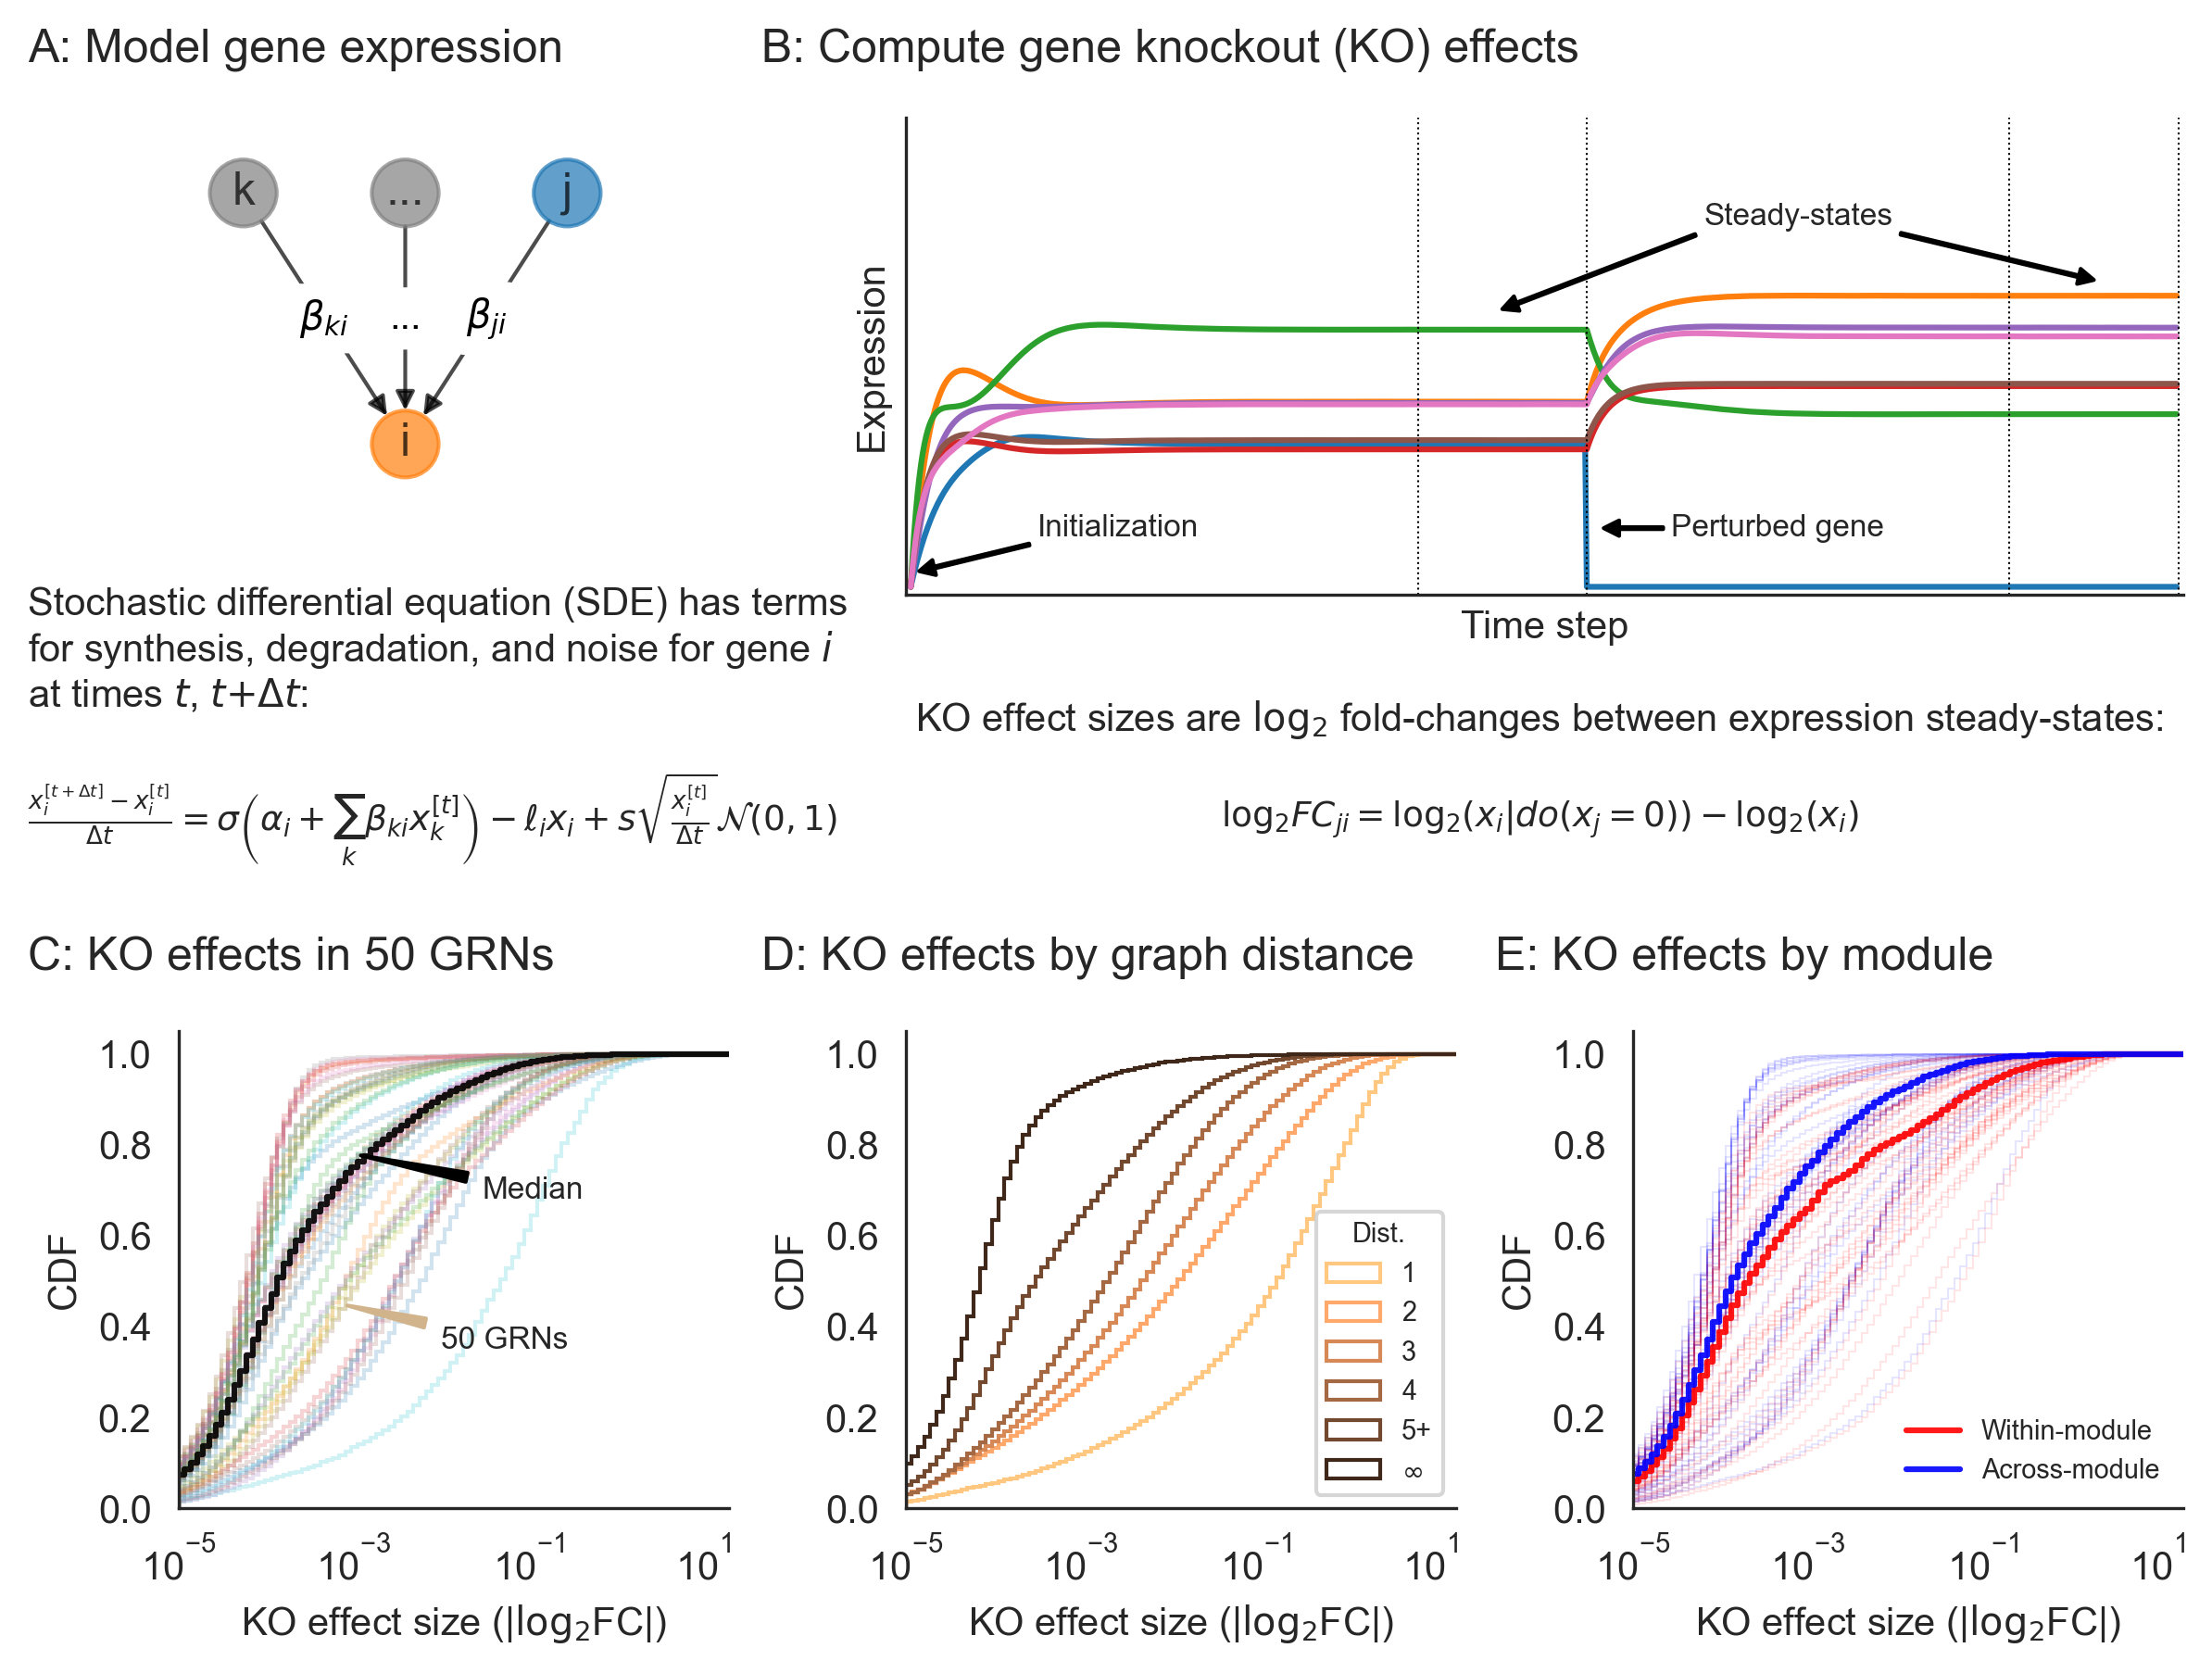

In [6]:
fig = plt.figure(figsize=(8,6), dpi=300)
grid = gs.GridSpec(2, 3, figure=fig)
sns.set_style('white');

### A: GENE EXPRESSION MODEL
ax=fig.add_subplot(grid[:1,:1]); 
fig.text(0.01, 0.995, 'A: Model gene expression', 
         fontsize=12, horizontalalignment='left', verticalalignment='top');

H=nx.from_edgelist([('j','i'), ('k','i'), ('k2','i')], create_using=nx.DiGraph())
pos={'i':[0,0], 'j':[0.5,1], 'k':[-0.5,1], 'k2':[0,1]}
nx.draw_networkx(H, pos, ax=ax, 
                 node_size=300, node_color=['tab:blue','tab:orange','grey','grey'], alpha=0.7, 
                 labels={'j':'j', 'i':'i', 'k':'k', 'k2':'...'}, with_labels=True, width=1)
nx.draw_networkx_edge_labels(H, pos, ax=ax, edge_labels={('j','i'):r'$\beta_{ji}$', ('k','i'):r'$\beta_{ki}$',('k2','i'):'...'}, rotate=0)
ax.set_xlim(-0.7, 1.0); 
ax.set_ylim(-0.6, 1.3);
ax.axis('off');

s='''Stochastic differential equation (SDE) has terms
for synthesis, degradation, and noise for gene {0}
at times {1}, {1}{2}:'''.format(r'$i$', r'$t$',r'$+\Delta t$')

fig.text(0.01, 0.66, s, fontsize=10, verticalalignment='top', horizontalalignment='left');

s=r'$\frac{x_i^{[t+\Delta t]} - x_i^{[t]}}{\Delta t} = \sigma\left(\alpha_i + \sum_k \beta_{ki} x_k^{[t]}\right) - \ell_i x_i + s \sqrt{\frac{x_i^{[t]}}{\Delta t}} \mathcal{N}(0,1)$'
fig.text(0.01, 0.52, s, fontsize=9, verticalalignment='center', horizontalalignment='left');

### B: RNA SCHEMATIC
ax=fig.add_subplot(grid[0,1:3])
fig.text(0.34, 0.995, 'B: Compute gene knockout (KO) effects', fontsize=12, horizontalalignment='left', verticalalignment='top');
ax.set_title('.', color='white', fontsize=12, alpha=0.0);

ax.plot(rna_trace);

ax.set_xlabel('Time step'.format(r'$\rightarrow$'));
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_ylabel('Expression');
ax.set_ylim(-0.01, 0.6);
ax.set_xlim(-3, 753);


ax.annotate('Initialization', xy=(5, 0.02), xytext=(75, 0.075),
            fontsize=8, ha='left', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );          

ax.annotate('Perturbed gene', xy=(410, 0.075), xytext=(450, 0.075), 
            fontsize=8, ha='left', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.annotate('Steady-states', xy=(350, 0.02+np.max(rna_trace[:400,:])), xytext=(525, 0.1+np.max(rna_trace)), 
            fontsize=8, ha='center', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.annotate('Steady-states', xy=(350*2, 0.02+np.max(rna_trace[-400:,:])), xytext=(525, 0.1+np.max(rna_trace)), 
            fontsize=8, ha='center', va='center', alpha=0.0,
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.axvline(300, ymin=np.min(rna_trace)/ax.get_ylim()[1], linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(400, ymin=np.min(rna_trace)/ax.get_ylim()[1], linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(650, linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(750, linewidth=0.5, linestyle='dotted', color='k');

sns.despine();

sns.despine();

fig.text(0.69, 0.58, 'KO effect sizes are {0} fold-changes between expression steady-states:'.format(r'$\log_2$'), 
         fontsize=10, verticalalignment='center', horizontalalignment='center');
fig.text(0.69, 0.52, r'$\log_2 FC_{ji} = \log_2(x_i | do(x_j = 0)) - \log_2(x_i)$',
         fontsize=9, verticalalignment='center', horizontalalignment='center');


### C: DISTRIBUTION OF KO EFFECTS (NETWORK)
ax=fig.add_subplot(grid[-1,0])
fig.text(0.01, 0.43, 'C: KO effects in 50 GRNs', fontsize=12);

cts=[]
for ix in nets:
    ct,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][highE[ix,:,:]].flatten()), 1e-5, 1e2), 
                        alpha=0.2,
                        linewidth=1,
                        bins=10**np.linspace(-5,2,100), 
                        density=True, 
                        cumulative=1, 
                        log=0, 
                        histtype='step'#,
                        #color='k'
                       )
    cts.append(ct)
cts=np.nanmedian(np.array(cts), axis=0)
ax.step(bins, [cts[0]]+list(cts), alpha=0.9, color='k')

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 2e1);
ax.set_xlabel('KO effect size (|{}FC|)'.format(r'$\log_2$')); 
ax.set_ylabel('CDF');

# annotation
ax.annotate('50 GRNs', xy=(7e-4, 0.45), xytext=(1e-2, 0.4),
            fontsize=8, va='top', ha='left',
            arrowprops=dict(arrowstyle='wedge', facecolor='tan', edgecolor='tan')
            );

ax.annotate('Median', xy=(1e-3, 0.78), xytext=(3e-2, 0.73), 
            fontsize=8, va='top', ha='left', 
            arrowprops=dict(arrowstyle='wedge', facecolor='k', edgecolor='k')
            );

### D: ACROSS NETWORK DISTANCES
ax=fig.add_subplot(grid[-1,1])
fig.text(0.34, 0.43, 'D: KO effects by graph distance', fontsize=12)

# histogram for each distance computed above
maxd = min(5, np.max(dists))
colors=np.array([cm.get_cmap('copper_r')(i) for i in np.linspace(0,0.8,maxd+1)])
for d in range(1, maxd):
    ax.hist(np.clip(np.random.choice(np.abs(ko[nets,:,:][(dists==d) & highE[nets,:,:]].flatten()), size=4000000), 1e-5, 1e2),
            bins=10**np.linspace(-5,2,100), 
            density=True, 
            cumulative=1, 
            log=0, 
            histtype='step',
            color=colors[d-1])

# clip at maxd
ax.hist(np.clip(np.random.choice(np.abs(ko[nets,:,:][(dists >= d) & np.isfinite(dists) & highE[nets,:,:]].flatten()), size=4000000), 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=True, 
        cumulative=1, 
        log=0, 
        histtype='step',
        color=colors[maxd-1])

# also include separate group for unreachable gene pairs
ax.hist(np.clip(np.random.choice(np.abs(ko[nets,:,:][np.isinf(dists) & highE[nets,:,:]].flatten()), size=4000000), 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=True, 
        cumulative=1, 
        log=0, 
        histtype='step',
        color=colors[maxd])

denom = dists.shape[0]*dists.shape[1]
counts,_ = np.histogram(dists[np.isfinite(dists)].flatten().clip(max=15), bins=np.arange(16))
denom = dists.shape[0]*dists.shape[1]
ax.legend([str(i) for i in range(1,maxd)]+['{}+'.format(maxd), r'$\infty$'],
          loc='lower right', 
          title='Dist.',
          fontsize='x-small', title_fontsize='x-small'
); 

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 2e1);
ax.set_xlabel('KO effect size (|{}FC|)'.format(r'$\log_2$')); 
ax.set_ylabel('CDF');



### E: WITHIN AND ACROSS MODULES
ax=fig.add_subplot(grid[-1,2])
fig.text(0.67, 0.43, 'E: KO effects by module', fontsize=12);

cts_in,cts_out=[],[]
for i,ix in enumerate(nets):
    cti,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][modules[ix,:,:] & highE[ix,:,:]].flatten()), 1e-5, 1e2),
                         alpha=0.1,
                         linewidth=0.5,
                         bins=10**np.linspace(-5,2,100), 
                         density=True, 
                         cumulative=1, 
                         log=0, 
                         histtype='step',
                         color='red',
                         label=None)
    cto,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][~modules[ix,:,:] & highE[ix,:,:]].flatten()), 1e-5, 1e2),
                         alpha=0.1,
                         linewidth=0.5,
                         bins=10**np.linspace(-5,2,100), 
                         density=True, 
                         cumulative=1, 
                         log=0, 
                         histtype='step',
                         color='blue',
                         label=None)    
    cts_in.append(cti)
    cts_out.append(cto)

cts_in=np.nanmedian(np.array(cts_in), axis=0)
cts_out=np.nanmedian(np.array(cts_out), axis=0)

ax.step(bins, [cts_in[0]]+list(cts_in), alpha=0.9, color='r', label='Within-module');
ax.step(bins, [cts_out[0]]+list(cts_out), alpha=0.9, color='b', label='Across-module');

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 2e1);
ax.set_xlabel('KO effect size (|{}FC|)'.format(r'$\log_2$')); 
ax.set_ylabel('CDF');
ax.legend(loc='lower right', fontsize='x-small', frameon=False);


### FINALLY
sns.despine();
plt.tight_layout(h_pad=10);
plt.savefig('png/fig3.png');

# Panels

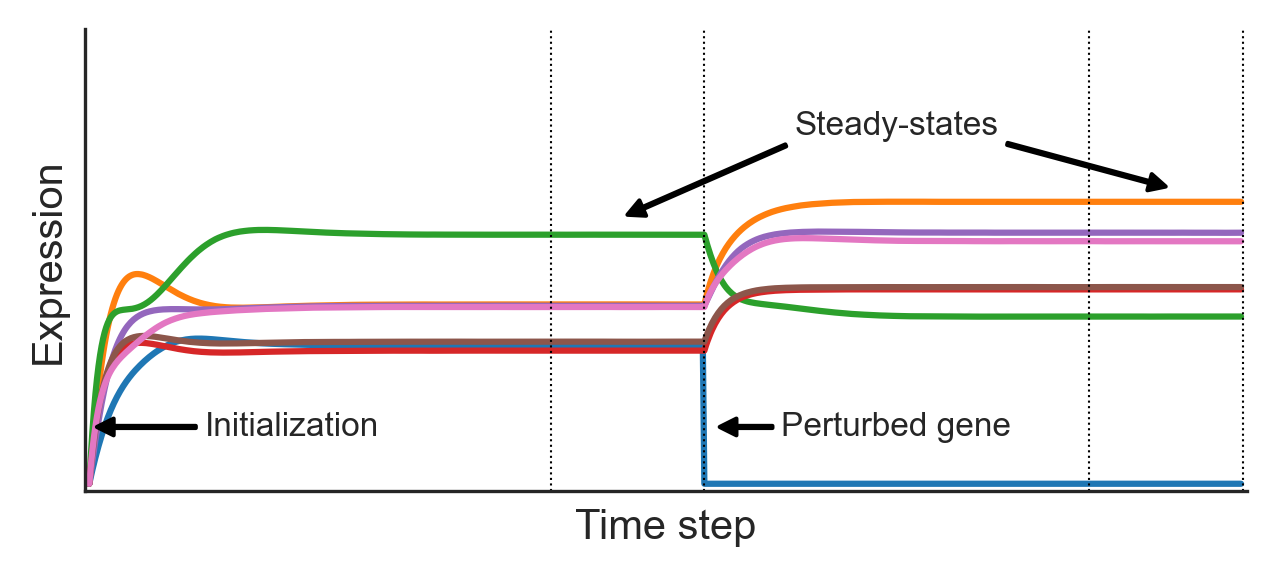

In [7]:
### A: RNA CONVERGES TO STEADY STATE
fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=300)

ax.plot(rna_trace);

ax.set_xlabel('Time step'.format(r'$\rightarrow$'));
ax.set_xticks([]);#[0,400]); ax.set_xticklabels(['Initialization','Perturbation']);
ax.set_yticks([]);
ax.set_ylabel('Expression');
ax.set_ylim(-0.01, 0.6);
ax.set_xlim(-3, 753);


ax.annotate('Initialization', xy=(5, 0.075), xytext=(75, 0.075),
            fontsize=8, ha='left', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );          

ax.annotate('Perturbed gene', xy=(410, 0.075), xytext=(450, 0.075), 
            fontsize=8, ha='left', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.annotate('Steady-states', xy=(350, 0.02+np.max(rna_trace[:400,:])), xytext=(525, 0.1+np.max(rna_trace)), 
            fontsize=8, ha='center', va='center',
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.annotate('Steady-states', xy=(350*2, 0.02+np.max(rna_trace[-400:,:])), xytext=(525, 0.1+np.max(rna_trace)), 
            fontsize=8, ha='center', va='center', alpha=0.0,
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.5, headlength=4, headwidth=4)
           );

ax.axvline(300, ymin=np.min(rna_trace)/ax.get_ylim()[1], linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(400, ymin=np.min(rna_trace)/ax.get_ylim()[1], linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(650, linewidth=0.5, linestyle='dotted', color='k');
ax.axvline(750, linewidth=0.5, linestyle='dotted', color='k');

sns.despine();

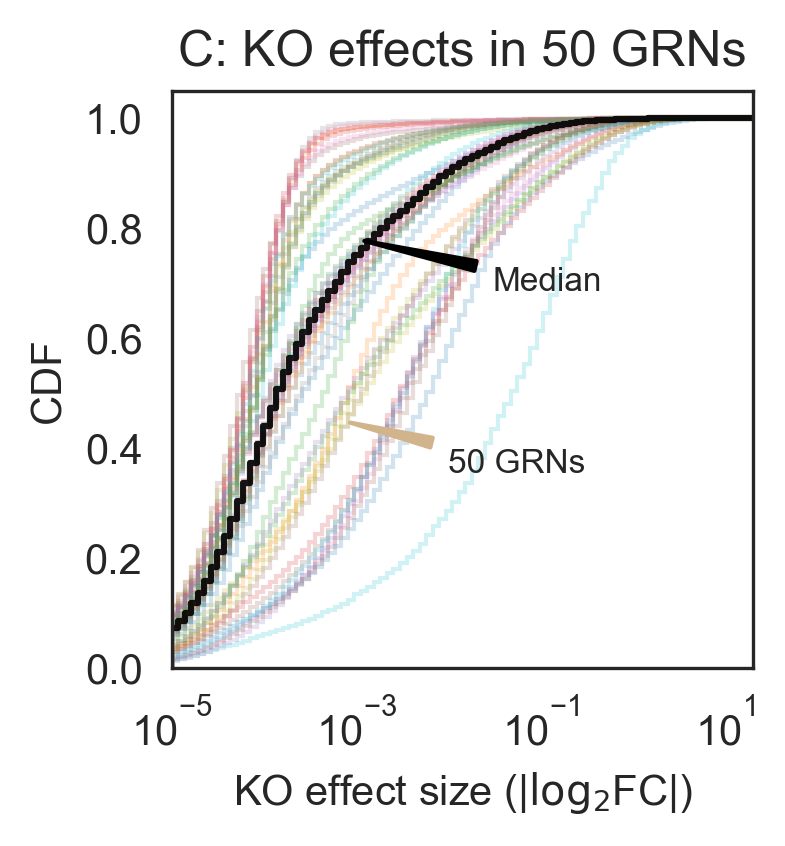

In [8]:
fig,ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=300)
ax.set_title('C: KO effects in 50 GRNs');

cts=[]
for ix in nets:
    ct,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][highE[ix,:,:]].flatten()), 1e-5, 1e2), 
                        alpha=0.2,
                        linewidth=1,
                        bins=10**np.linspace(-5,2,100), 
                        density=True, 
                        cumulative=1, 
                        log=0, 
                        histtype='step'
                       )
    cts.append(ct)
cts=np.nanmedian(np.array(cts), axis=0)
ax.step(bins, [cts[0]]+list(cts), alpha=0.9, color='k')

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 2e1);
ax.set_xlabel('KO effect size (|{}FC|)'.format(r'$\log_2$')); 
ax.set_ylabel('CDF');

# annotation
ax.annotate('50 GRNs', xy=(7e-4, 0.45), xytext=(1e-2, 0.4),
            fontsize=8, va='top', ha='left',
            arrowprops=dict(arrowstyle='wedge', facecolor='tan', edgecolor='tan')
            );

ax.annotate('Median', xy=(1e-3, 0.78), xytext=(3e-2, 0.73), 
            fontsize=8, va='top', ha='left', 
            arrowprops=dict(arrowstyle='wedge', facecolor='k', edgecolor='k')
            );

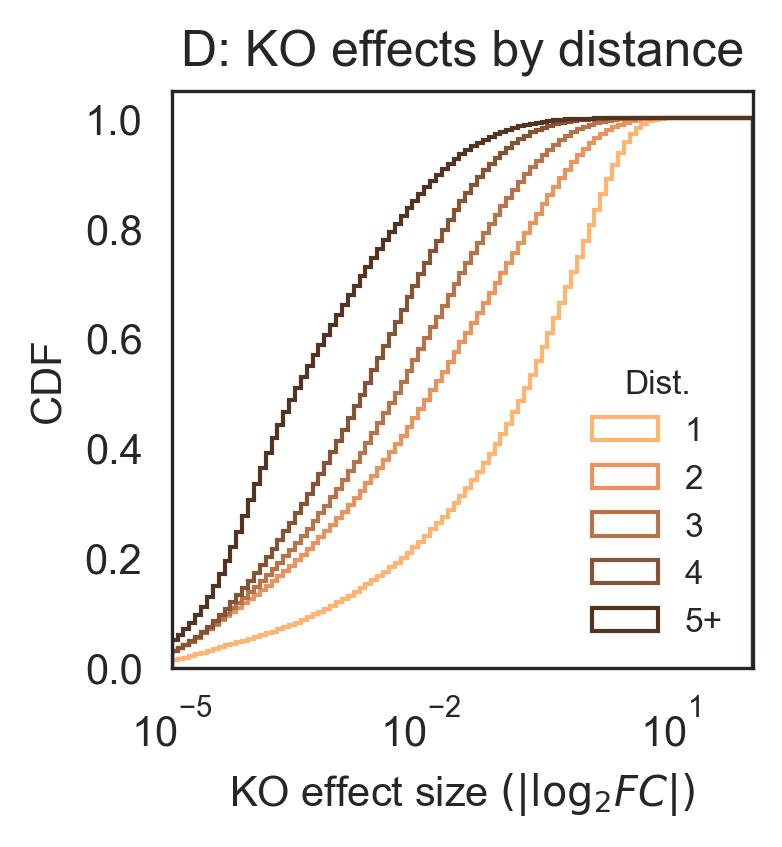

In [9]:
### D: ACROSS NETWORK DISTANCES
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5), dpi=300);

ax.set_title('D: KO effects by distance');

# histogram for each distance computed above
maxd = min(5, np.max(dists))
colors=np.array([cm.get_cmap('copper_r')(i) for i in np.linspace(0.1,0.9,maxd+1)])
for d in range(1, maxd):
    ax.hist(np.clip(np.random.choice(np.abs(ko[nets,:,:][(dists==d) & highE[nets,:,:]].flatten()), size=4000000), 1e-5, 1e2),
            bins=10**np.linspace(-5,2,100), 
            density=True, 
            cumulative=1, 
            log=0, 
            histtype='step', 
            color=colors[d-1])

# clip at maxd
ax.hist(np.clip(np.random.choice(np.abs(ko[nets,:,:][(dists >= d) & np.isfinite(dists) & highE[nets,:,:]].flatten()), size=4000000), 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=True, 
        cumulative=1, 
        log=0, 
        histtype='step', 
        color=colors[maxd-1])

denom = dists.shape[0]*dists.shape[1]
counts,_ = np.histogram(dists[np.isfinite(dists)].flatten().clip(max=15), bins=np.arange(16))
denom = dists.shape[0]*dists.shape[1]
ax.legend(['1','2','3','4','5+'], title='Dist.', fontsize=8, title_fontsize=8, frameon=False, loc='lower right');

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 1e2);
ax.set_xlabel('KO effect size '+r'$(|\log_2 FC|)$'); 
ax.set_ylabel('CDF');

# Supplement

Direct:
390034 of 502705 effects at |log2FC| > 0.01
Mediated:
25419162 of 114814461 effects at |log2FC| > 0.01
Null:
1554570 of 82313969 effects at |log2FC| > 0.01


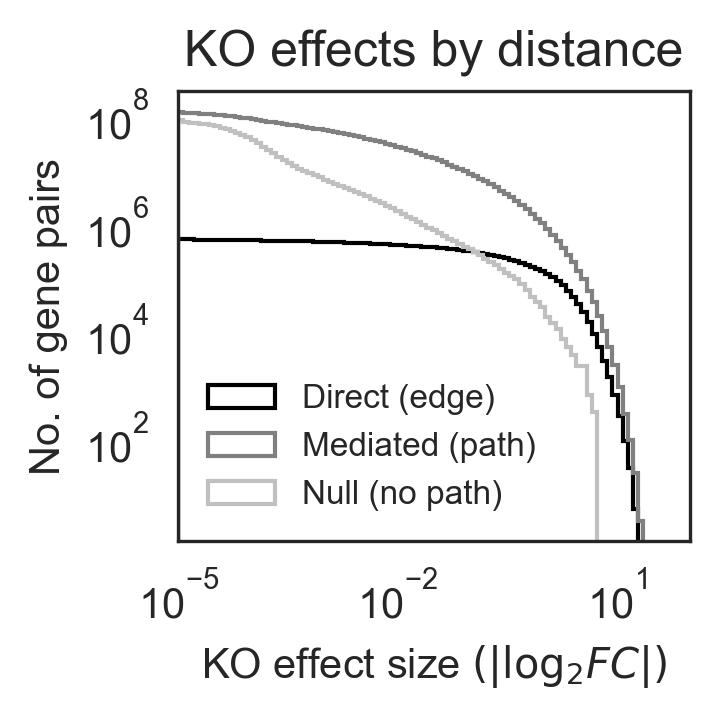

In [10]:
### BINNED DISTANCES
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5), dpi=300);

ax.set_title('KO effects by distance');

sf=np.stack(np.eye(2000, dtype=bool) for _ in nets)
tx=1e-2

# histogram for edges
dx=(dists==1) & highE[nets,:,:] & ~sf
xx=np.abs(ko[nets,:,:][dx]).flatten()
print('Direct:\n{0} of {1} effects at |log2FC| > {2}'.format(np.sum(xx > tx), np.sum(dx), tx))
ax.hist(np.clip(xx, 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=False, 
        cumulative=-1, 
        log=0, 
        histtype='step', 
        label='Direct (edge)',
        color='black')

# reachable gene pairs
dx=(dists > 1) & np.isfinite(dists) & highE[nets,:,:] & ~sf
xx=np.abs(ko[nets,:,:][dx]).flatten()
print('Mediated:\n{0} of {1} effects at |log2FC| > {2}'.format(np.sum(xx > tx), np.sum(dx), tx))
ax.hist(np.clip(xx, 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=False, 
        cumulative=-1, 
        log=0, 
        histtype='step', 
        label='Mediated (path)',
        color='gray')

# unreachable gene pairs
dx=~np.isfinite(dists) & highE[nets,:,:] & ~sf
xx=np.abs(ko[nets,:,:][dx]).flatten()
print('Null:\n{0} of {1} effects at |log2FC| > {2}'.format(np.sum(xx > tx), np.sum(dx), tx))
ax.hist(np.clip(xx, 1e-5, 1e2),
        bins=10**np.linspace(-5,2,100), 
        density=False, 
        cumulative=-1, 
        log=0, 
        histtype='step', 
        label='Null (no path)',
        color='silver')

#ax.axvline(tx, linestyle='dotted', linewidth=1, color='red');

ax.legend(fontsize=8, loc='lower left', frameon=False);

# labels and scaling
ax.loglog(); ax.set_xlim(1e-5, 1e2);
ax.set_xlabel('KO effect size '+r'$(|\log_2 FC|)$'); 
ax.set_ylabel('No. of gene pairs');

# save
plt.tight_layout()
plt.savefig('png/supplement/fig_s3a.png');

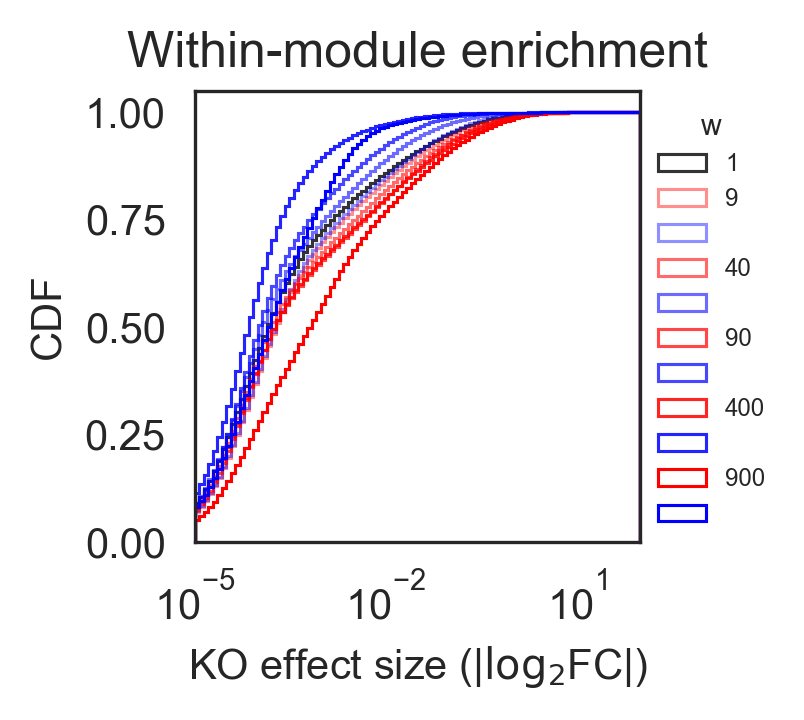

In [11]:
### EFFECT OF MODULARITY TERM
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.5), dpi=300);

ax.set_title('Within-module enrichment');

nets2 = pd.concat([networks.query('r==@row.r & k==@row.k & delta_in==@row.delta_in & delta_out==@row.delta_out')
                   for _,row in networks.iloc[1153:1154,:].iterrows()])

legend=[]
wvals=sorted(list(set(nets2.w.values.astype(int))))

for w,a in zip(wvals, np.linspace(0.3,1,len(wvals))):
    ix = sorted(nets2.query('w==@w').index - 1)
    
    cti,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][modules[ix,:,:] & highE[ix,:,:]].flatten()), 1e-5, 1e2),
                         alpha=a if w > 1 else 0.8,
                         bins=10**np.linspace(-5,2,100), 
                         density=True, 
                         cumulative=1, 
                         log=0, 
                         histtype='step',
                         linewidth=0.75,
                         color='red' if w > 1 else 'black',
                         label='{}'.format(w))
    if w > 1:
        cto,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][~modules[ix,:,:] & highE[ix,:,:]].flatten()), 1e-5, 1e2),
                             alpha=a,
                             bins=10**np.linspace(-5,2,100), 
                             density=True, 
                             cumulative=1, 
                             log=0, 
                             linewidth=0.75,
                             histtype='step',
                             color='blue',
                             label=' '.format(w))    

# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 1e2);
ax.set_xlabel('KO effect size (|{}FC|)'.format(r'$\log_2$')); 
ax.set_ylabel('CDF');
ax.legend(fontsize='xx-small', title='w', title_fontsize='x-small', bbox_to_anchor=(0.99, 1), frameon=False);

plt.tight_layout();
plt.savefig('png/supplement/fig_s3b.png');

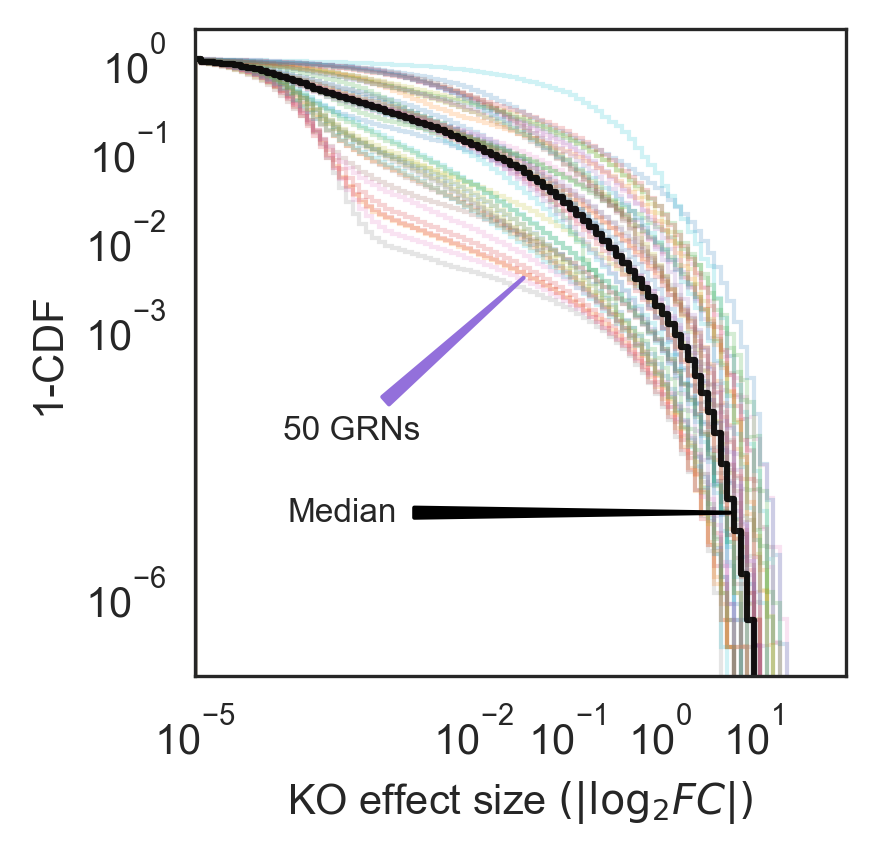

In [12]:
### TALK VERSION OF A PLOT
fig, ax = plt.subplots(1, 1, figsize=(2.8,2.8), dpi=300);

cts=[]
for ix in nets:
    ct,bins,_ = ax.hist(np.clip(np.abs(ko[ix,:,:][np.ix_(~lowE[ix,:],~lowE[ix,:])].flatten()), 1e-5, 1e2), 
                        alpha=0.2,
                        linewidth=1,
                        bins=10**np.linspace(-5,2,100), 
                        density=True, 
                        cumulative=-1, 
                        log=True, 
                        histtype='step'#,
                        #color='k'
                       )
    cts.append(ct)
cts=np.nanmedian(np.array(cts), axis=0)
ax.step(bins, [cts[0]]+list(cts), alpha=0.9, color='k')


# labels and scaling
ax.semilogx(); ax.set_xlim(1e-5, 1e2);
ax.set_yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-6]);
ax.set_xticks([1e-5, 1e-2, 1e-1, 1e0, 1e1]);
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('KO effect size '+r'$(|\log_2 FC|)$'); 
ax.set_ylabel('1-CDF');

ax.annotate('50 GRNs', xy=(4e-2, 4e-3), xytext=(0.9e-4, 1e-4), # (2.2, 6e-5), (0.9e-4, 6e-5)
            fontsize=8, va='top', 
            arrowprops=dict(arrowstyle='wedge', facecolor='mediumpurple', edgecolor='mediumpurple')
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );

ax.annotate('Median', xy=(7, 8e-6), xytext=(1e-4, 8e-6), 
            fontsize=8, va='center', 
            arrowprops=dict(arrowstyle='wedge', facecolor='k', edgecolor='k')
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );



# Numbers

In [13]:
q = [np.sum(np.abs(ko[ix][highE[ix] & ~np.eye(2000, dtype=bool)]) >= 1) for ix in tqdm(range(networks.shape[0]))]
np.median(q)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [02:20<00:00, 13.65it/s]


5295.5

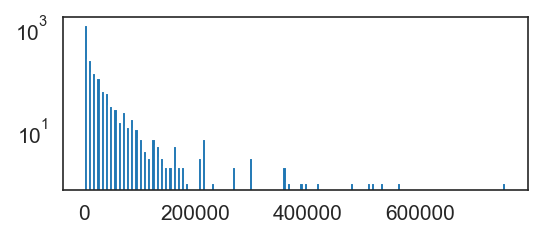

In [14]:
plt.figure(figsize=(4,1.5), dpi=150)
plt.hist(q, bins=100);
plt.semilogy();

# Wiggles

In [15]:
meanabsko=[np.mean(np.abs(ko[ix])) for ix in tqdm(range(networks.shape[0]))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1920/1920 [00:19<00:00, 97.64it/s]


(1695, 329)

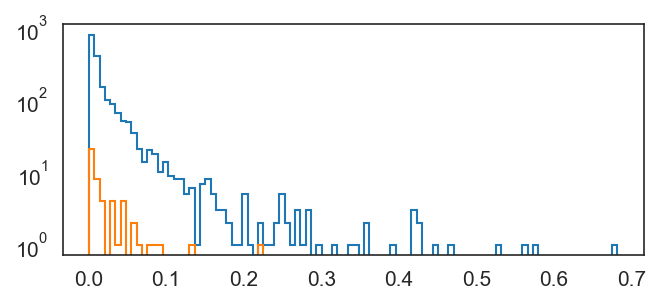

In [16]:
plt.figure(figsize=(5,2), dpi=150)

_,bins,_=plt.hist(meanabsko, bins=100, histtype='step'); plt.semilogy();
plt.hist(np.array(meanabsko)[nets], bins=bins, histtype='step'); plt.semilogy();

nets[np.argmax(np.array(meanabsko)[nets])], nets[np.argmin(np.array(meanabsko)[nets])]

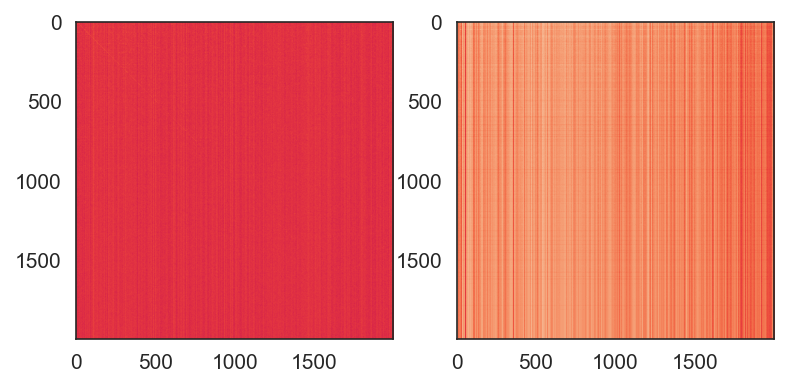

In [17]:
fig,ax=plt.subplots(1, 2, figsize=(6,3), dpi=150)
ax[0].imshow(np.log2(np.abs(ko[329,:,:]))); 
ax[1].imshow(np.log2(np.abs(ko[1695,:,:])));

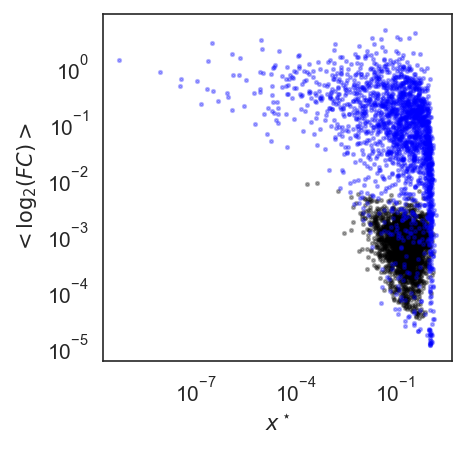

In [18]:
plt.figure(figsize=(3,3), dpi=150);
plt.plot(rna[329,:], np.mean(np.abs(ko[329,:,:]), axis=0), 'k.', alpha=0.3, ms=3); 
plt.plot(rna[1695,:], np.mean(np.abs(ko[1695,:,:]), axis=0), 'b.', alpha=0.3, ms=3); 
plt.loglog();
plt.xlabel(r'$x^\star$'); plt.ylabel(r'$<\log_2(FC)>$');

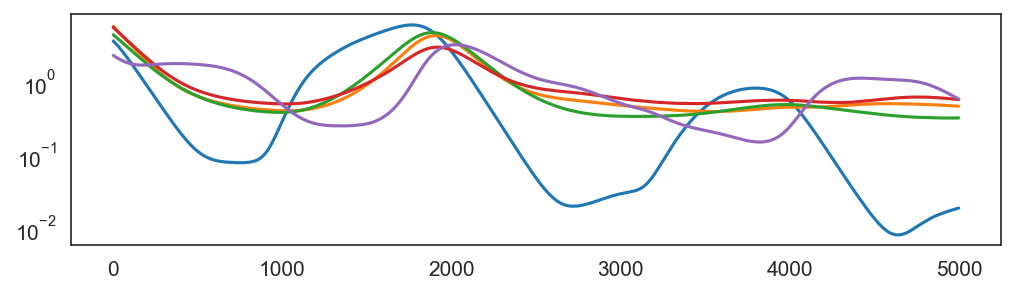

In [19]:
plt.figure(figsize=(8,2), dpi=150)
genes = np.array([i for i in np.argsort(np.mean(np.abs(ko[1695,:,:]), axis=0))[::-1] if rna[1695,i] > 1e-1])[:5]

xt = nx.read_gpickle(home + '/grns/graph.1696.gpickle'
                    ).set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :]
                    ).simulate_rna(x0 = rna[1695, :], dt = 0.01, s = 1e-4, tmax = 5002, step = 20000, burnin = 0, save = False)

plt.plot(xt[:,genes] / np.mean(xt[:,genes], axis=0)); plt.semilogy();

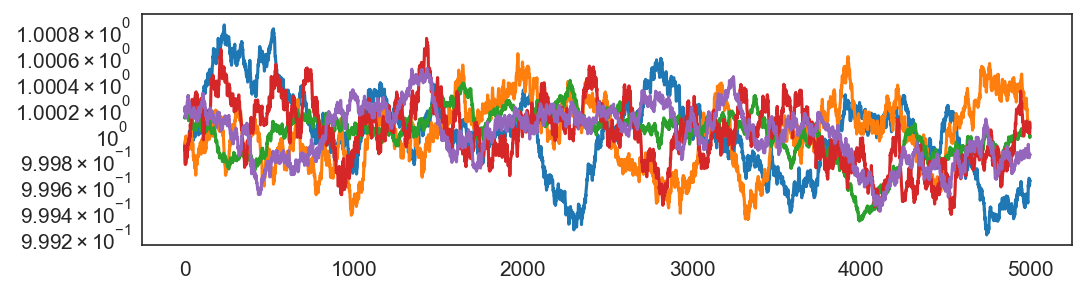

In [20]:
plt.figure(figsize=(8,2), dpi=150)
genes = np.array([i for i in np.argsort(np.mean(np.abs(ko[269,:,:]), axis=0))[::-1] if rna[269,i] > 1e-1])[:5]

xt = nx.read_gpickle(home + '/grns/graph.270.gpickle'
                    ).set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :]
                    ).simulate_rna(x0 = rna[269, :], dt = 0.01, s = 1e-4, tmax = 5002, step = 20000, burnin = 0, save = False)

plt.plot(xt[:,genes] / np.mean(xt[:,genes], axis=0)); plt.semilogy();